<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [1]:
import pandas as pd
past = pd.read_csv('../dat/past.csv.gz')

In [2]:
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the perspective of classification, is the data balanced?

In [3]:
purchased = past['Purchased?'][past['Purchased?']==1].sum()
total =len(past)

In [4]:
print(f"{purchased/total*100}% made a purchase")

34.38% made a purchase


In [5]:
past['Purchased?'].value_counts()

0    3281
1    1719
Name: Purchased?, dtype: int64

- most people do not buy and likley window shop
- the data is fairly balanced as we would expect the target response to not have an entirely uniform distribution

3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [6]:
X = past.drop(columns=['product_id', 'user_id'], axis=1)
y = X.pop('Purchased?')

In [7]:
X.shape, y.shape

((5000, 34), (5000,))

In [8]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

In [10]:
scaled = StandardScaler()
pca = PCA(n_components=5)

In [11]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(scaled, pca)

In [12]:
X_reduced = pipeline.fit_transform(X)

In [13]:
X_reduced.shape

(5000, 5)

In [14]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [15]:
pipeline.named_steps['pca'].explained_variance_ratio_

array([0.10282145, 0.09445751, 0.06508456, 0.05127938, 0.04225588])

6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [16]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [17]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

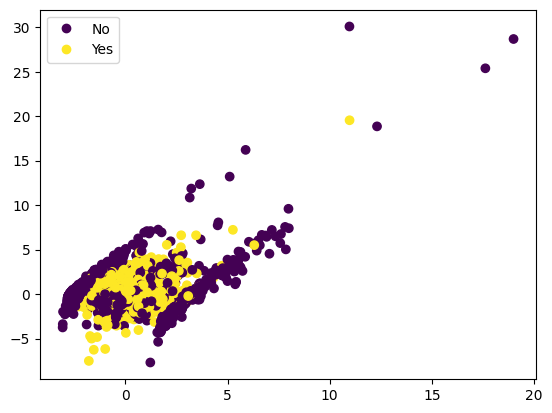

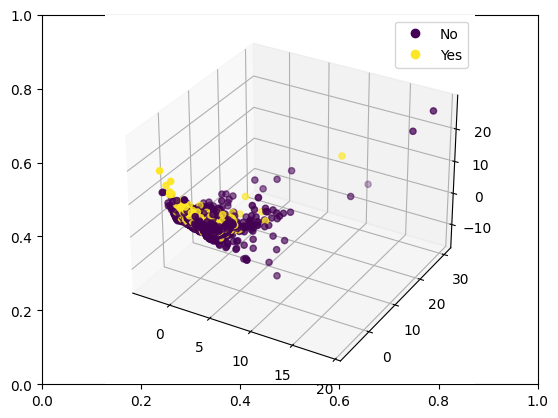

In [18]:
visualize_2pcs(X_reduced,y)
visualize_3pcs(X_reduced,y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [19]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def train(X, y, standardize = True) -> None:
    
    scaler = StandardScaler()
    pca = PCA()
    log_reg = LogisticRegression(class_weight='balanced')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    
    if standardize == True:
        pipeline = make_pipeline(scaler, log_reg)
    else:
        pipeline = make_pipeline(log_reg)
        
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    # print classification report
    print(classification_report(y_test, predictions))
    

Now apply the pipeline on the all the features `X` and review the performance

In [20]:
train(X,y)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       649
           1       0.55      0.52      0.54       351

    accuracy                           0.68      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.68      0.68      0.68      1000



In [21]:
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5))])

Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

- We should not inlcude standardization as X_reduced already applies it

In [22]:
train(X_reduced, y, standardize=False)

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       649
           1       0.50      0.54      0.52       351

    accuracy                           0.65      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.65      0.65      0.65      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 
    *YOUR ANSWER HERE*

- results for the full dataset are a bit better on all metrics (precision, recall, f1-score)
- the reduced dataset would be better for interpretation and for analyzing the results of the principal components

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [23]:
from sklearn.cluster import KMeans

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [24]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=10)
        fitted = km.fit(X)
        inertias.append(fitted.inertia_)
        
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

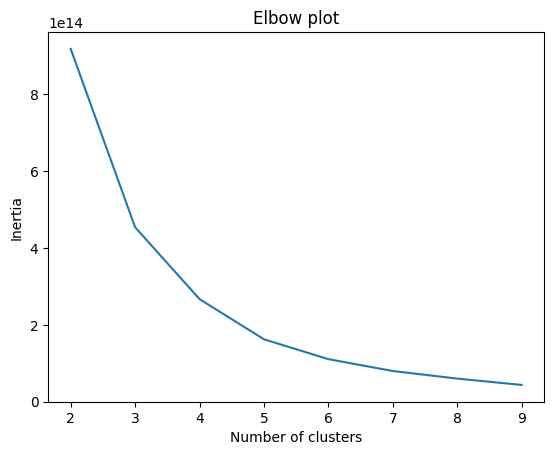

In [25]:
visualize_elbow(X,range(2,10))

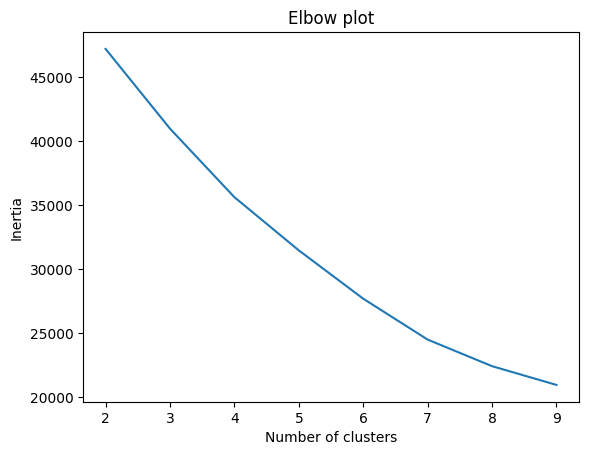

In [26]:
visualize_elbow(X_reduced, range(2,10))

4. What are the disadvantage to use the Elbow method? 

- the disadvantage of the elbow method is there may not always be a sharp discernable "elbow" to use from the plot, such as above with X_reduced.
- additionally, it is a subjectively determined by the researcher, and there could very well be ambiguity as to where the elbow is. 

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [27]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.24985074697295986
For n_clusters = 3 The average silhouette_score is : 0.2578856049124881
For n_clusters = 4 The average silhouette_score is : 0.2715920108646473
For n_clusters = 5 The average silhouette_score is : 0.27730526128970484
For n_clusters = 6 The average silhouette_score is : 0.24236029739550868
For n_clusters = 7 The average silhouette_score is : 0.24805860743669972
For n_clusters = 8 The average silhouette_score is : 0.254983057453017


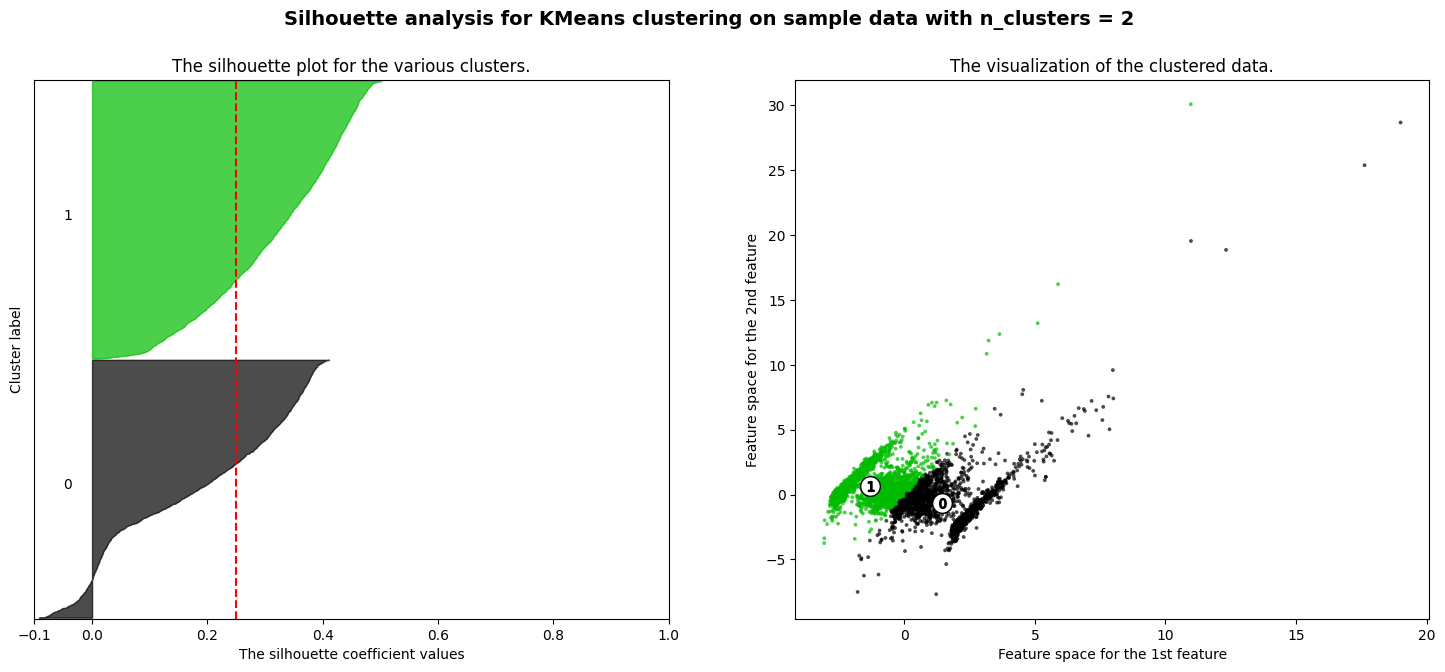

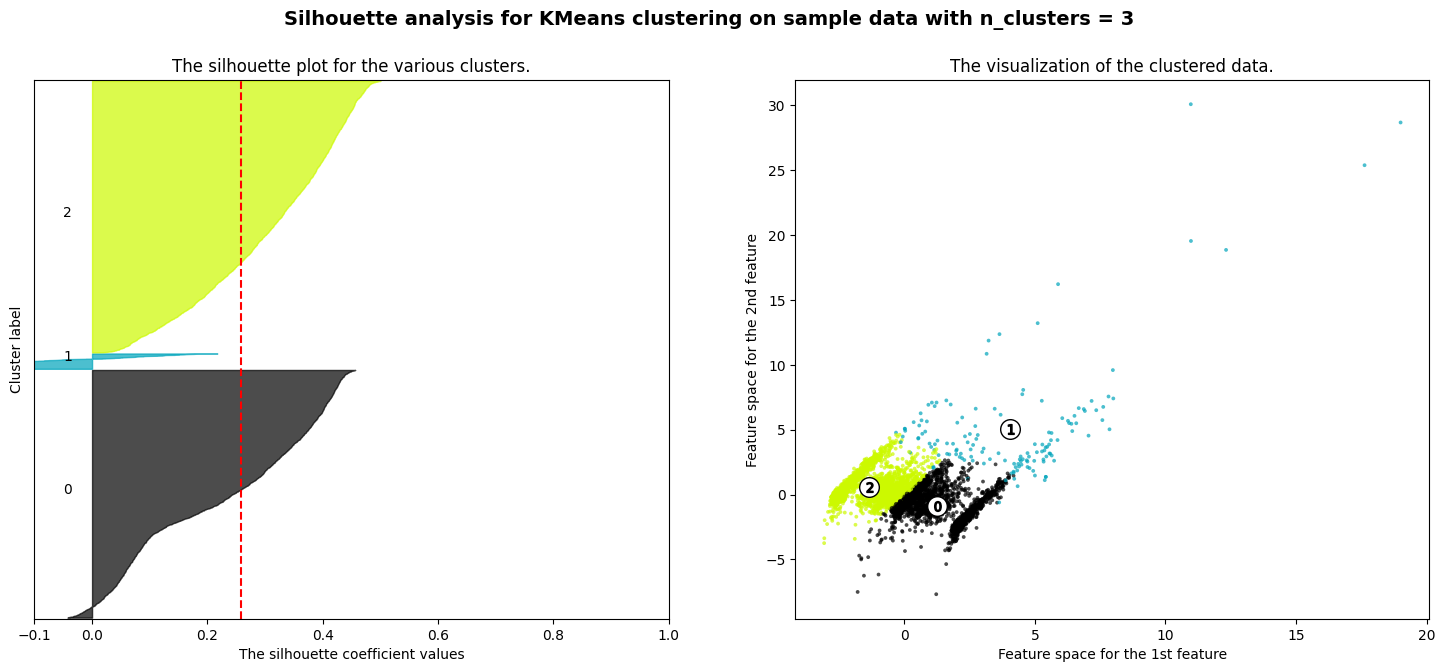

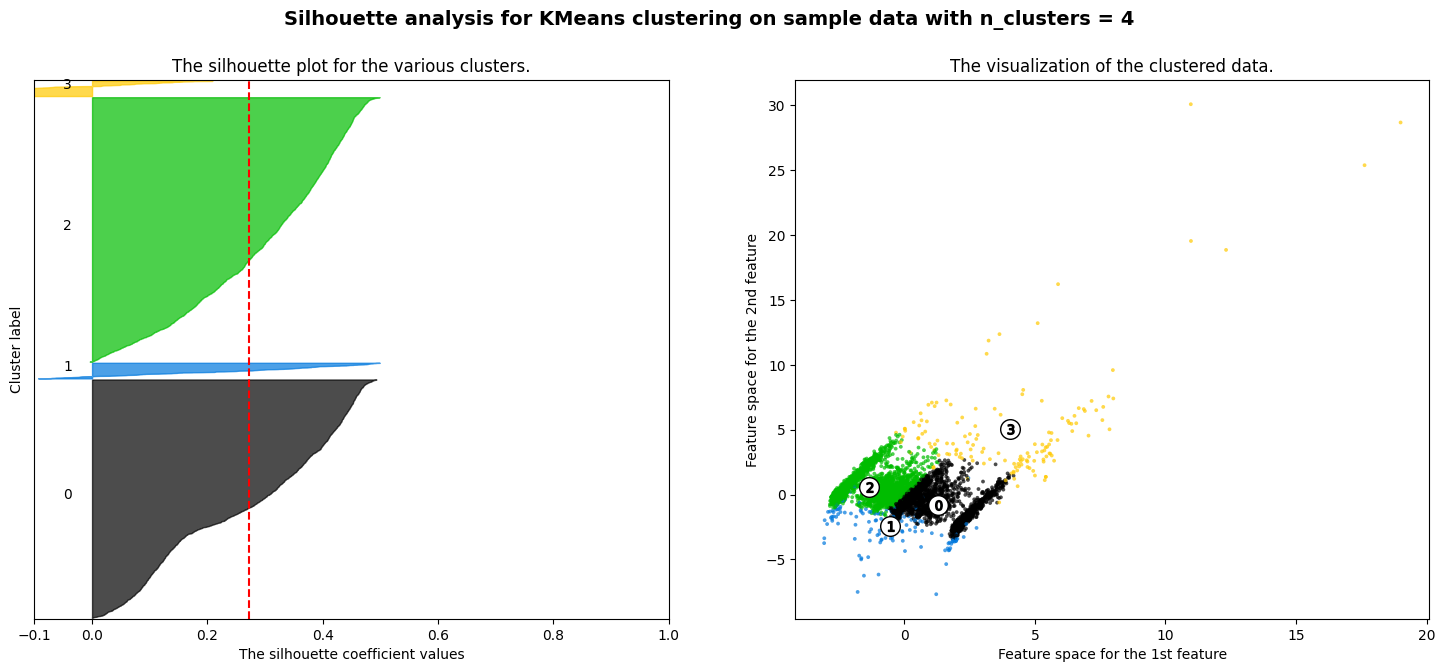

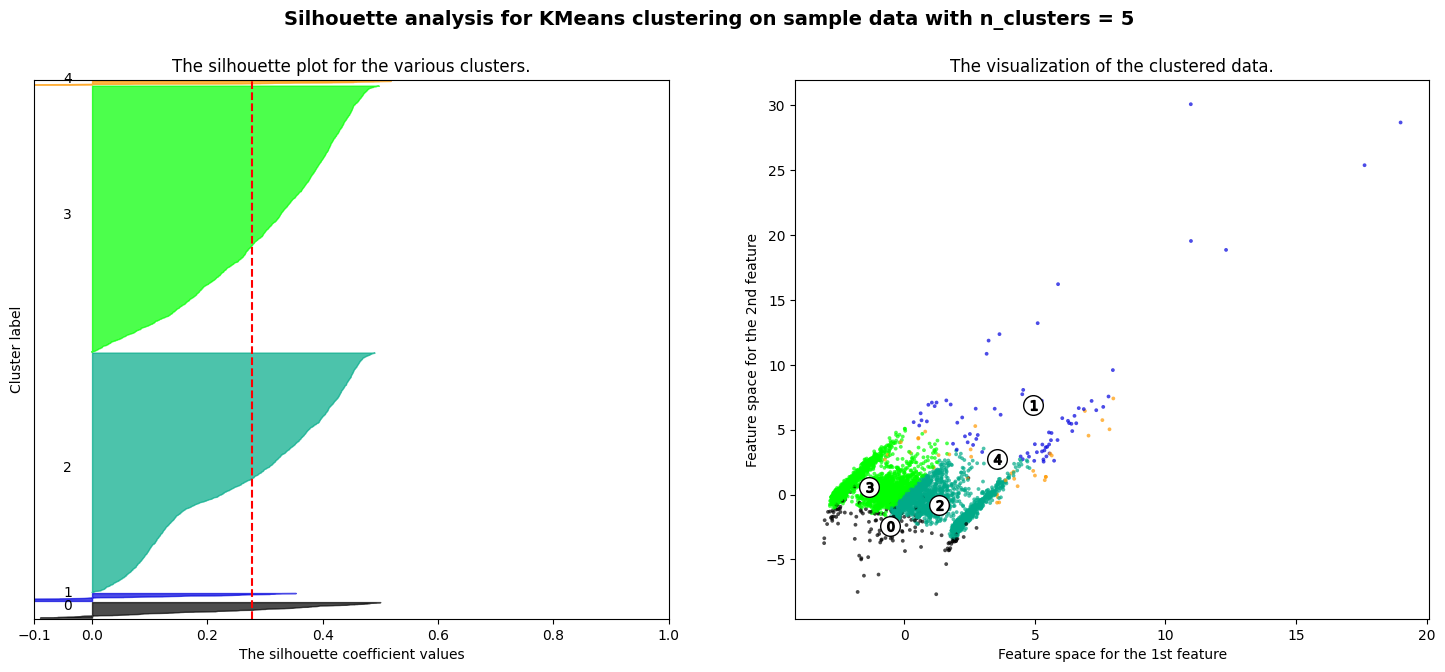

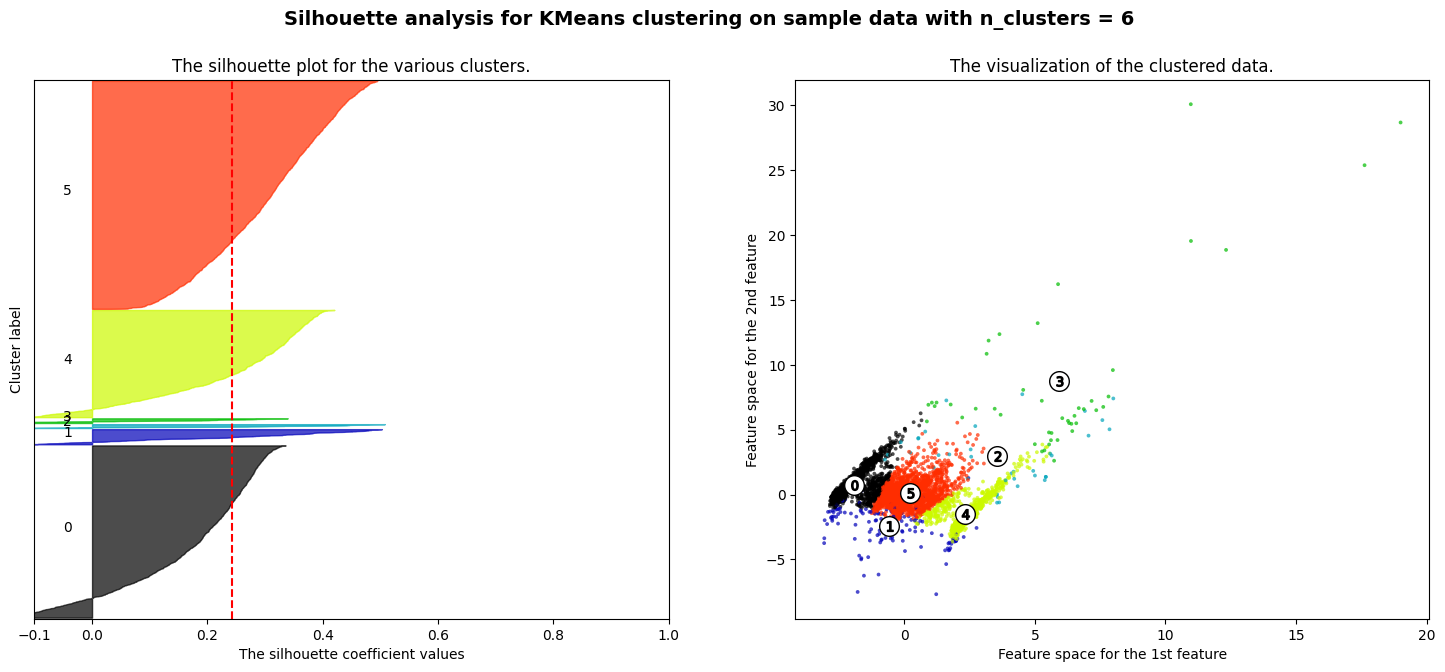

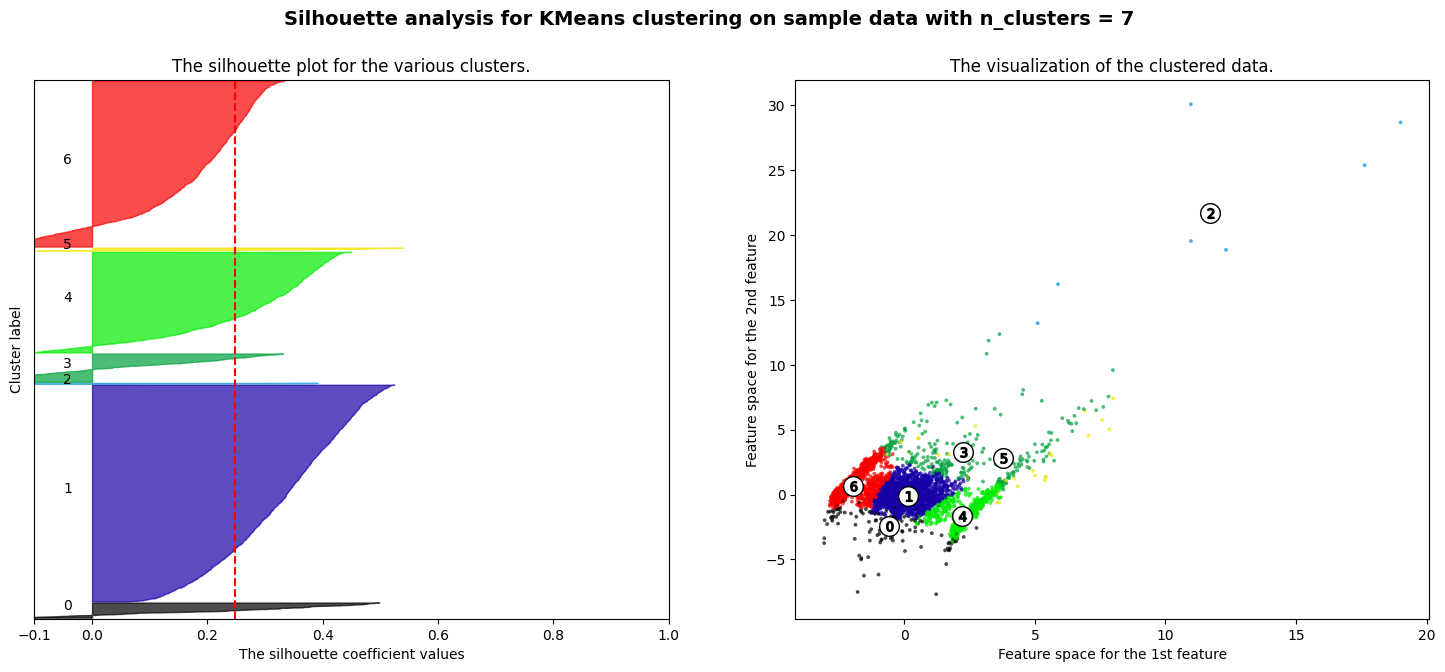

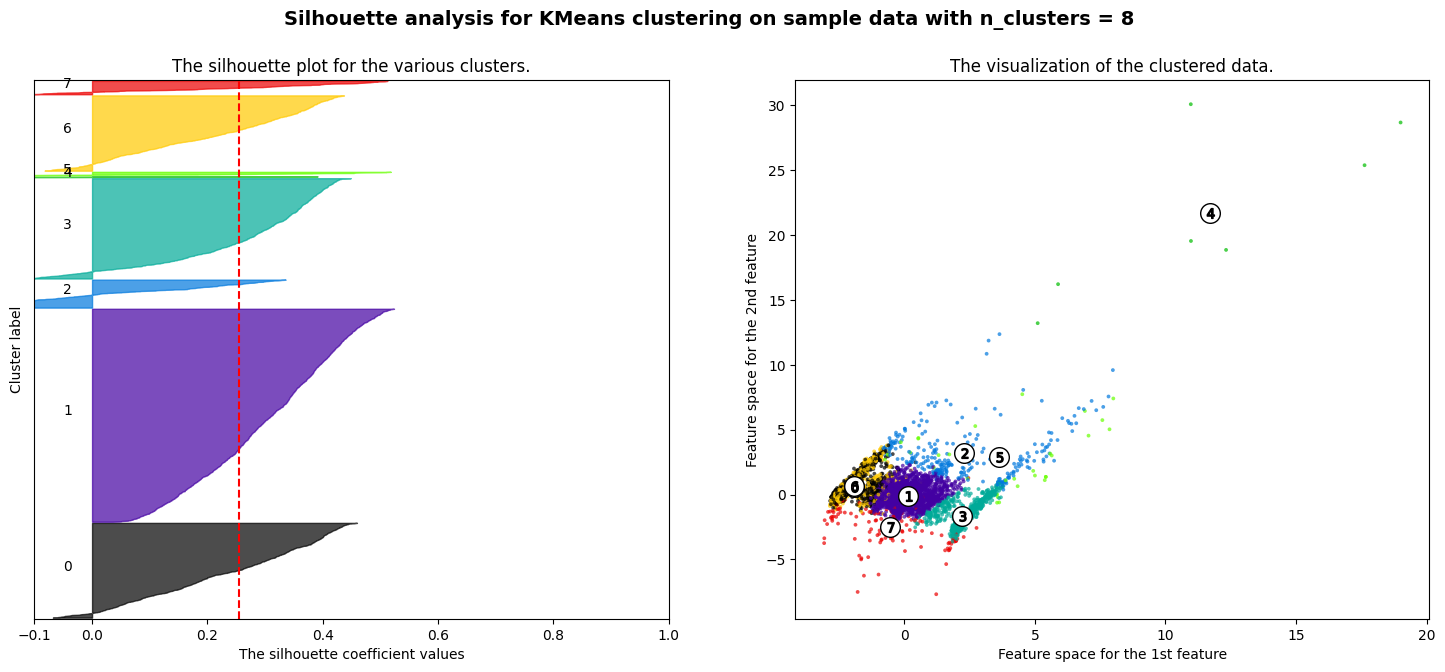

In [28]:
visualize_silhouette(8, X_reduced)

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [29]:
# 5 clusters has the highest silhouette score
km = KMeans(n_clusters=5)

In [30]:
fitted = km.fit(X_reduced)

7. What is the size of each cluster? 

In [31]:
label_list = list(km.labels_)
label_list

[3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 3,
 4,
 0,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 0,
 1,
 1,
 3,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 4,
 3,
 1,
 4,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 4,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 1,
 0,
 1,
 1,
 4,
 3,
 3,
 1,
 1,
 1,
 0,
 3,
 3,
 3,
 1,
 3,
 4,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 0,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 1,
 1,
 2,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 3,
 4,
 3,
 1,
 1,
 4,
 4,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 1,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 0,
 1,
 3,
 4,
 3,
 1,
 2,
 1,
 4,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,


In [32]:
len([num for num in label_list if num ==1])

2496

In [33]:
from collections import Counter

Counter(label_list).keys() 

dict_keys([3, 1, 4, 0, 2])

In [34]:
Counter(label_list).values()

dict_values([2247, 2496, 147, 75, 35])

8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [35]:
past['cluster_pca'] = km.labels_
past.head()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0,3
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0,3
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0,3
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0,3
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0,1


9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

Let's look at the cluster across different dimensions to see if we can spot any trends.

In [36]:
import seaborn as sns

def gridPlot(df,col,x,y,hue):
    
    g = sns.FacetGrid(df, col=col)
    g.map_dataframe(sns.scatterplot, x=x, y=y, hue=hue,style=hue)
    g.add_legend()

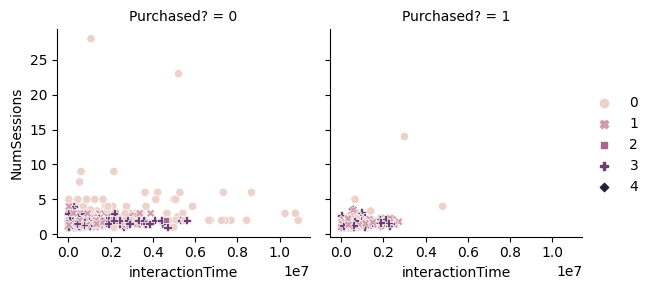

In [37]:
gridPlot(past, "Purchased?", "interactionTime", "NumSessions", "cluster_pca")

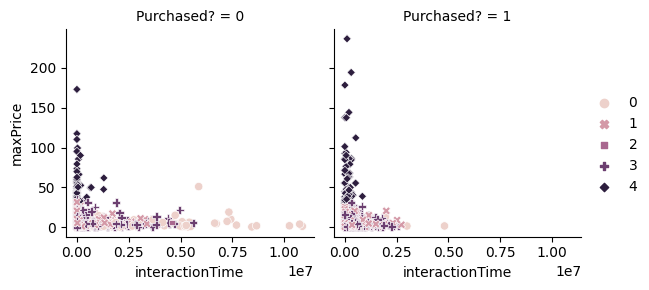

In [38]:
gridPlot(past, "Purchased?", "interactionTime", "maxPrice", "cluster_pca")

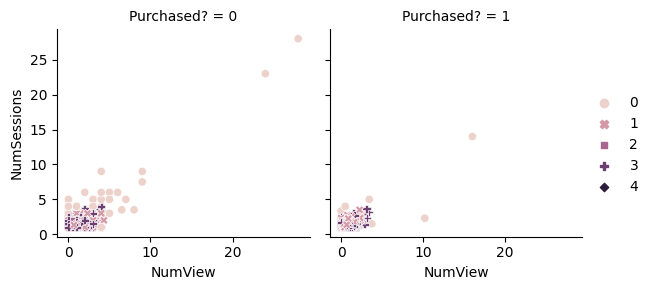

In [39]:
gridPlot(past, "Purchased?", "NumView", "NumSessions", "cluster_pca")

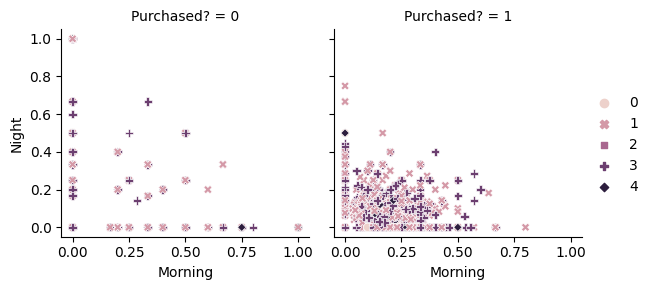

In [40]:
gridPlot(past, "Purchased?", "Morning", "Night", "cluster_pca")

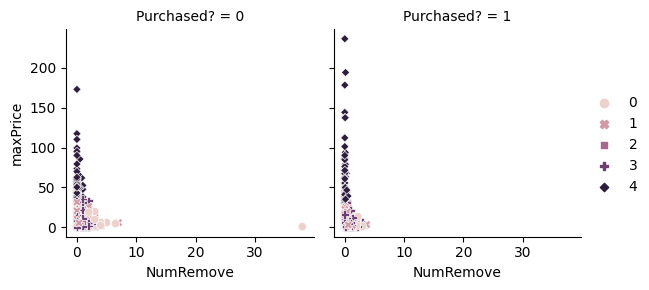

In [41]:
gridPlot(past, "Purchased?", "NumRemove", "maxPrice", "cluster_pca")

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

The assumptions for k-means:
- variance of each feature is spherical
- common variance among features
- equal samples in each cluster

K-Means may not be a great cluster algorithm for this problem based on the above assumptions.

In [42]:
past.cluster_pca.value_counts()

1    2496
3    2247
4     147
0      75
2      35
Name: cluster_pca, dtype: int64

In [79]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-50, random_state=0).fit(X_reduced)

In [82]:
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

In [84]:
n_clusters_

77

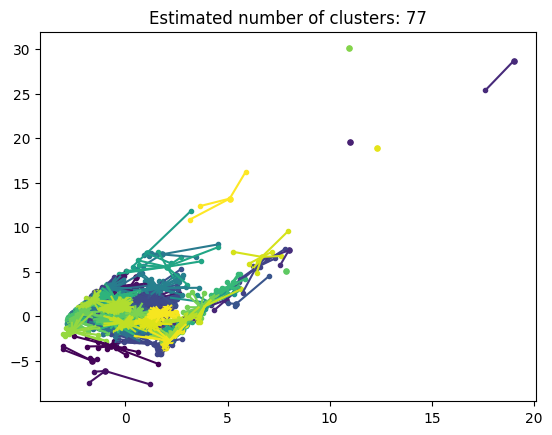

In [87]:
import matplotlib.pyplot as plt

plt.close("all")
plt.figure(1)
plt.clf()

colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, 77)))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_reduced[cluster_centers_indices[k]]
    plt.scatter(
        X_reduced[class_members, 0], X_reduced[class_members, 1], color=col["color"], marker="."
    )
    plt.scatter(
        cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o"
    )
    for x in X_reduced[class_members]:
        plt.plot(
            [cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"]
        )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

11. Jot down recommendations or followup steps, detailing the reasons.

- K-Means may not be the best solution here, as we have uneven samples across the clusters and there may be many clusters as the Affinity Propogation model would suggest.

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [44]:
new = pd.read_csv('../dat/new.csv.gz')

In [45]:
assert new.shape == (30091, 5)

In [46]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

In [47]:
past.shape, new.shape

((5000, 38), (30091, 5))

- there are far more data points in new (test set) than past (training set)
- the training data (past) had many more features 37 with 1 target, and the test set has only 4 features and 1 target

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [48]:
past_id = past['product_id'].unique()
new_id = new['product_id'].unique()

In [49]:
list(set(past_id).intersection(new_id))

[]

In [50]:
np.intersect1d(past_id, new_id)

array([], dtype=int64)

- there are no product IDs common to both data sets

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [51]:
purchased = len(new[new['Purchased?']==1])
purchased

10359

In [52]:
print(f"{round(purchased/len(new)*100,2)}%")

34.43%


5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [53]:
X = new.drop(columns=['product_id', 'Purchased?'], axis=1)
y = new['Purchased?']

In [54]:
X.sample(3)

,maxPrice,minPrice,Category
11022,0.475455,0.471818,0.909091
2426,5.065217,5.050435,1.130435
23664,7.460000,7.460000,1.000000


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [56]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [57]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [58]:
log_reg_pred = LogisticRegression(class_weight='balanced').fit(X_train, y_train).predict(X_test)

/Users/dinushdealwis/miniforge3/envs/mle-course/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [59]:
print(classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      3986
           1       0.80      0.50      0.61      2033

    accuracy                           0.79      6019
   macro avg       0.79      0.72      0.73      6019
weighted avg       0.79      0.79      0.77      6019



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [60]:
X = np.concatenate([X_train, X_test])

In [61]:
X.shape

(30091, 3)

In [62]:
# incorrect shape in notebook
#assert X.shape == (35091, 3)

In [63]:
assert X.shape == (30091,3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [64]:
# YOUR CODE HERE
id = np.ones(y_test.shape) * -1
y = np.concatenate([y_train, id])

In [65]:
y

array([ 1.,  1.,  0., ..., -1., -1., -1.])

In [66]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [67]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import LabelPropagation

lab_spread = LabelSpreading(kernel='knn',alpha=0.01)

In [68]:
lab_spread

LabelSpreading(alpha=0.01, kernel='knn')

In [69]:
fitted = lab_spread.fit(X,y)

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [70]:
predictions = fitted.transduction_
predictions

array([1., 1., 0., ..., 0., 0., 0.])

In [71]:
semi_sup_rows = X_train.shape[0]
semi_sup_rows

24072

In [72]:
predictions[semi_sup_rows:]

array([0., 1., 0., ..., 0., 0., 0.])

In [73]:
semi_sup_preds = predictions[semi_sup_rows:]
semi_sup_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [74]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [75]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.86      0.94      0.89      3986
           1       0.85      0.69      0.76      2033

    accuracy                           0.85      6019
   macro avg       0.85      0.81      0.83      6019
weighted avg       0.85      0.85      0.85      6019



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [76]:
y_pred = log_reg_pred

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      3986
           1       0.80      0.50      0.61      2033

    accuracy                           0.79      6019
   macro avg       0.79      0.72      0.73      6019
weighted avg       0.79      0.79      0.77      6019



- the semi-supervised recal is better for the made purchase classification 

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)